# Problem Statement

Here at SolaraTech, I'm tackling a crucial problem: how to squeeze the most power out of our solar panels day in, day out.

The goal is to create models that can accurately peg our daily solar efficiency into three buckets: Low, Medium, and High.

If I nail this, we'll have a smart AI model that can look at tomorrow's weather and tell us how our panels will perform.

---

## Data Ingestion

The analysis starts by ingesting data from SQLite databases using a custom `DataIngestion` class. 

This class does the following:

1. Connects to a SQLite database
2. Retrieves the name of the first table in the database
3. Fetches all data from that table into a pandas DataFrame

This class is then used to load our weather and air quality data.

In [1]:
import sqlite3
import pandas as pd

class DataIngestion():
    def __init__ (self, db_path):
        self.db_path = db_path

    def get_df(self):
        # establish a connection with the database using sqlite3
        conn = sqlite3.connect(self.db_path)

        # obtain table name
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        table_name = cursor.fetchone()[0]        

        # query to fetch the data and load the data into a pandas DataFrame
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)

        cursor.close()
        conn.close()

        return df
  
weather_ingestor  = DataIngestion('data/weather.db')
air_quality_ingestor = DataIngestion('data/air_quality.db')

# Load weather and air quality data
weather_df = weather_ingestor.get_df()
air_quality_df = air_quality_ingestor .get_df()


# Data Overview
Firstly let's take an overview of the columns, data types, and non-null counts for each dataset.

## Air Quality

In [2]:
air_quality_df.head()

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,18,19,21,13,17,64,64,66,-,66


In [4]:
air_quality_df.describe()


,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
count,3875,3875,3836,3836,3836,3836,3836,3836,3836,3836,3836,3836
unique,3197,3197,74,86,76,85,68,112,113,108,117,105
top,a5f11eb5-41b1-4c1c-bae5-9d536ee2e58c,13/09/2014,11,10,9,8,10,52,52,52,52,53
freq,5,5,308,290,313,318,322,261,236,260,208,224


In [5]:
print(air_quality_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data_ref      3875 non-null   object
 1   date          3875 non-null   object
 2   pm25_north    3836 non-null   object
 3   pm25_south    3836 non-null   object
 4   pm25_east     3836 non-null   object
 5   pm25_west     3836 non-null   object
 6   pm25_central  3836 non-null   object
 7   psi_north     3836 non-null   object
 8   psi_south     3836 non-null   object
 9   psi_east      3836 non-null   object
 10  psi_west      3836 non-null   object
 11  psi_central   3836 non-null   object
dtypes: object(12)
memory usage: 363.4+ KB
None


In [ ]:
print("\nMissing values in Air Quality Data:")
print(air_quality_df.isnull().sum())


Missing values in Air Quality Data:
data_ref         0
date             0
pm25_north      39
pm25_south      39
pm25_east       39
pm25_west       39
pm25_central    39
psi_north       39
psi_south       39
psi_east        39
psi_west        39
psi_central     39
dtype: int64


### Key Observations
From the above overview, it is obvious that:
1. The dtypes of the variables are all objects, and are likely strings. -> Will need to change the types to integers and floats for numerical data, date into datetime data and string data as strings
2. There are missing numerical values denoted by '-' and '--'. -> Will need to convert them into NA for further preprocessing. 


## Weather data

In [ ]:
weather_df.head()

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


In [6]:
weather_df.describe()

,Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa)
count,3501.000000,3501.000000,3517.000000,3517.000000,3517.000000
mean,7.018320,28.682376,52.946062,97.366761,1008.668467
std,1.389904,20.788299,25.842174,5.043705,3.513724
min,0.000000,2.000000,-60.700000,68.600000,998.000000
25%,6.710000,17.000000,58.400000,96.700000,1006.000000
50%,7.400000,22.000000,58.900000,100.000000,1009.000000
75%,7.840000,30.000000,59.400000,100.000000,1011.000000
max,9.150000,100.000000,61.800000,100.000000,1020.000000


In [7]:
print(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3517 non-null   object 
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object 
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object 
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object 
 6   Min Temperature (deg C)        3517 non-null   object 
 7   Maximum Temperature (deg C)    3517 non-null   object 
 8   Min Wind Speed (km/h)          3517 non-null   object 
 9   Max Wind Speed (km/h)          3502 non-null   object 
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Wet Bulb Temperature (deg F)   3517 non-null   f

In [6]:
print("Missing values in Weather Data:")
print(weather_df.isnull().sum())

Missing values in Weather Data:
data_ref                          0
date                              0
Daily Rainfall Total (mm)         0
Highest 30 Min Rainfall (mm)      0
Highest 60 Min Rainfall (mm)      0
Highest 120 Min Rainfall (mm)     0
Min Temperature (deg C)           0
Maximum Temperature (deg C)       0
Min Wind Speed (km/h)             0
Max Wind Speed (km/h)            15
Sunshine Duration (hrs)          16
Cloud Cover (%)                  16
Wet Bulb Temperature (deg F)      0
Relative Humidity (%)             0
Air Pressure (hPa)                0
Dew Point Category                0
Wind Direction                    0
Daily Solar Panel Efficiency      0
dtype: int64


In [11]:
# Print the set of unique string values in the column
weather_string_columns = [
    'Dew Point Category','Wind Direction', 'Daily Solar Panel Efficiency'    
]

for string_cols in weather_string_columns:
    unique_strings = set(weather_df[string_cols].unique())
    print(f"Unique strings in {string_cols} before : {unique_strings}")

Unique strings in Dew Point Category before : {'Normal', 'MODERATE', 'HIGH', 'Below Average', 'High', 'high', 'Extreme', 'VERY LOW', 'VL', 'High Level', 'L', 'Very Low', 'Minimal', 'Very High', 'low', 'LOW', 'H', 'Moderate', 'moderate', 'VH', 'VERY HIGH', 'M', 'very low', 'very high', 'Low'}
Unique strings in Wind Direction before : {'north', 'NE.', 'WEST', 'northwest', 'Southward', 'east', 'NE', 'N', 'SE', 'W.', 'E', 'NW.', 'SOUTHEAST', 'Northward', 'NORTH', 'SW', 'S', 'NORTHEAST', 'southeast', 'west', 'W', 'NW', 'EAST', 'S.', 'northeast', 'E.', 'N.', 'south', 'SOUTH', 'SW.', 'NORTHWEST', 'SE.'}
Unique strings in Daily Solar Panel Efficiency before : {'Low', 'Medium', 'High'}


## Key Observations
From the above overview, it is obvious that:
1. The dtypes of the variables are all objects, and are likely strings. -> Will need to change the types to integers and floats for numerical data, date into datetime data and string data as strings
2. There are missing numerical values denoted by '-' and '--'. -> Will need to convert them into NA and so further preprocessing. 
3. For the string columns of Dew Point Category and Wind Direction, the strings must be cleaned and be consistent (with casing and shortforms) -> Will need to clean the strings


# Merge the dataset

The 2 tables will be merged based on the key: `data_ref` 

Duplicated rows will be removed and the table will be saved back to the database

In [8]:
import pandas as pd
import sqlite3

class DataMerger:
    def __init__(self, db1_path, db2_path, table1_name, table2_name, merge_column):
        """
        Initialize the DataMerger class.
        
        :param db1_path: Path to the first SQLite database.
        :param db2_path: Path to the second SQLite database.
        :param table1_name: Table name in the first database.
        :param table2_name: Table name in the second database.
        :param merge_column: Column name to merge the datasets on.
        """
        self.db1_path = db1_path
        self.db2_path = db2_path
        self.table1_name = table1_name
        self.table2_name = table2_name
        self.merge_column = merge_column

    def load_data(self):
        """
        Load data from the specified tables in the two databases.

        :return: DataFrames for the two tables.
        """
        with sqlite3.connect(self.db1_path) as conn1:
            df1 = pd.read_sql_query(f"SELECT * FROM {self.table1_name}", conn1)
        
        with sqlite3.connect(self.db2_path) as conn2:
            df2 = pd.read_sql_query(f"SELECT * FROM {self.table2_name}", conn2)
        
        return df1, df2

    def merge_remove_duplicate(self):
        """
        Merge the datasets on the specified column and remove duplicate rows.
        """
        df1, df2 = self.load_data()
        
        # Merge the datasets
        merged_df = pd.merge(df1, df2, on=self.merge_column, how="inner")
        
        # Drop duplicate rows
        merged_df.drop_duplicates(inplace=True)
        
        return merged_df

    def save_cleaned_data(self, merged_df, output_db_path, output_table_name):
        """
        Save the cleaned DataFrame back into a SQLite database.

        :param merged_df: The cleaned DataFrame to save.
        :param output_db_path: Path to the output SQLite database.
        :param output_table_name: Name of the table to save the cleaned data.
        """
        with sqlite3.connect(output_db_path) as conn:
            merged_df.to_sql(output_table_name, conn, if_exists="replace", index=False)

# Example usage
if __name__ == "__main__":
    # Replace with actual file paths and table names
    db1_path = "data/weather.db"
    db2_path = "data/air_quality.db"
    table1_name = "weather"
    table2_name = "air_quality"
    merge_column = ["data_ref", "date"]
    output_db_path = "data/merged_data.db"  # Path to save the cleaned data
    output_table_name = "merged_data"  # Table name for cleaned data

    merger = DataMerger(db1_path, db2_path, table1_name, table2_name, merge_column)
    merged_df = merger.merge_remove_duplicate()

    # Save the cleaned data back into a database
    merger.save_cleaned_data(merged_df, output_db_path, output_table_name)

    # Display the cleaned data
    print(merged_df.head())


                               data_ref        date Daily Rainfall Total (mm)  \
0  4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea  01/04/2014                         -   
1  c9d3c825-fd94-4e61-a4bc-2cf0f2208de0  02/04/2014                         0   
2  6d445ffb-d4c2-4f94-a27e-224fabe46d10  03/04/2014                         0   
3  7a404c50-710f-451a-9a42-a66bb783a3d0  04/04/2014                         0   
4  0d3194a7-ad1a-456e-9bf8-b1bae730977b  05/04/2014                      23.4   

  Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
0                            2                            2   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                         15.2                         17.2   

  Highest 120 Min Rainfall (mm) Min Temperature (deg C)  \
0                             2                    28.4   
1               

# Data Cleaning
We will see what are other things that needs to be clean other than those stated in Key observations section above.

You can run the next code cell if need to read in merged_data.db again

In [11]:
import sqlite3
import pandas as pd

# Path to the merged database
merged_db_path = "data/merged_data.db"

# Establish a connection to the database
conn = sqlite3.connect(merged_db_path)

# Read the merged data into a DataFrame
merged_df = pd.read_sql_query("SELECT * FROM merged_data", conn)

# Close the connection
conn.close()

# Display the first few rows of the DataFrame
print(merged_df.head())

                               data_ref        date Daily Rainfall Total (mm)  \
0  4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea  01/04/2014                         -   
1  c9d3c825-fd94-4e61-a4bc-2cf0f2208de0  02/04/2014                         0   
2  6d445ffb-d4c2-4f94-a27e-224fabe46d10  03/04/2014                         0   
3  7a404c50-710f-451a-9a42-a66bb783a3d0  04/04/2014                         0   
4  0d3194a7-ad1a-456e-9bf8-b1bae730977b  05/04/2014                      23.4   

  Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
0                            2                            2   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                         15.2                         17.2   

  Highest 120 Min Rainfall (mm) Min Temperature (deg C)  \
0                             2                    28.4   
1               

In [12]:
merged_df['date'] = pd.to_datetime(merged_df['date'], dayfirst=True)

### Convert multiple columns to numeric
columns_to_convert = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central', 'psi_north', 'psi_south',
                      'psi_east', 'psi_west', 'psi_central']

# Convert each column to int using pd.to_numeric with errors='coerce' it convert non-numeric values to NaN.
for col in columns_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# List of columns to convert to float
columns_to_convert2 = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
                      'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)']

# Convert each column to float using pd.to_numeric with errors='coerce' it convert non-numeric values to NaN.
for col in columns_to_convert2:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').astype(float)

print("\nDataFrame after conversion:")
print(merged_df.info())


DataFrame after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3236 non-null   object        
 1   date                           3236 non-null   datetime64[ns]
 2   Daily Rainfall Total (mm)      2918 non-null   float64       
 3   Highest 30 Min Rainfall (mm)   2909 non-null   float64       
 4   Highest 60 Min Rainfall (mm)   2910 non-null   float64       
 5   Highest 120 Min Rainfall (mm)  2916 non-null   float64       
 6   Min Temperature (deg C)        2917 non-null   float64       
 7   Maximum Temperature (deg C)    2916 non-null   float64       
 8   Min Wind Speed (km/h)          2913 non-null   float64       
 9   Max Wind Speed (km/h)          2904 non-null   float64       
 10  Sunshine Duration (hrs)        3222 non-null   float64 

## Check if there are negative values

Sometimes, if the data is thoroughly cleaned but you can find negative values this might be directional indication.

In [16]:
import numpy as np
(merged_df.select_dtypes(include=[np.number]) < 0).any(axis=0)

Daily Rainfall Total (mm)        False
Highest 30 Min Rainfall (mm)     False
Highest 60 Min Rainfall (mm)     False
Highest 120 Min Rainfall (mm)    False
Min Temperature (deg C)          False
Maximum Temperature (deg C)      False
Min Wind Speed (km/h)            False
Max Wind Speed (km/h)             True
Sunshine Duration (hrs)          False
Cloud Cover (%)                  False
Wet Bulb Temperature (deg F)      True
Relative Humidity (%)            False
Air Pressure (hPa)               False
pm25_north                       False
pm25_south                       False
pm25_east                        False
pm25_west                        False
pm25_central                     False
psi_north                        False
psi_south                        False
psi_east                         False
psi_west                         False
psi_central                      False
dtype: bool

Since minimum wind speed >= 0, and maximum wind speed >= minimum wind speed, all the negative max wind speed values will be converted to its absolute value. 

### Wet bulb temperature

We will print out a row and check the negative wet bulb temperature

In [20]:
merged_df[merged_df['Wet Bulb Temperature (deg F)'] < 0][['Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Relative Humidity (%)', 'Wet Bulb Temperature (deg F)']].head(1)

,Min Temperature (deg C),Maximum Temperature (deg C),Relative Humidity (%),Wet Bulb Temperature (deg F)
0,28.4,32.4,100.0,-59.3


Based on the Wet Bulb Calculator and the data printed above (max temperature and relative humidity), the Wet Bulb temperature should be 53.6 degree Farenheit. (Żuławińska, 2024)

We will assume all other rows with negative wet bulb temperatures, were suppose to be positive, so we will get the abosulute values. 

In [13]:
## List of columns to compute absolute values
columns_to_abs = ['Max Wind Speed (km/h)', 'Wet Bulb Temperature (deg F)']

# Apply absolute values for selected columns
merged_df[columns_to_abs] = merged_df[columns_to_abs].abs()

## Missing values
We can see that quite a few of the columns have around 10% of missing values

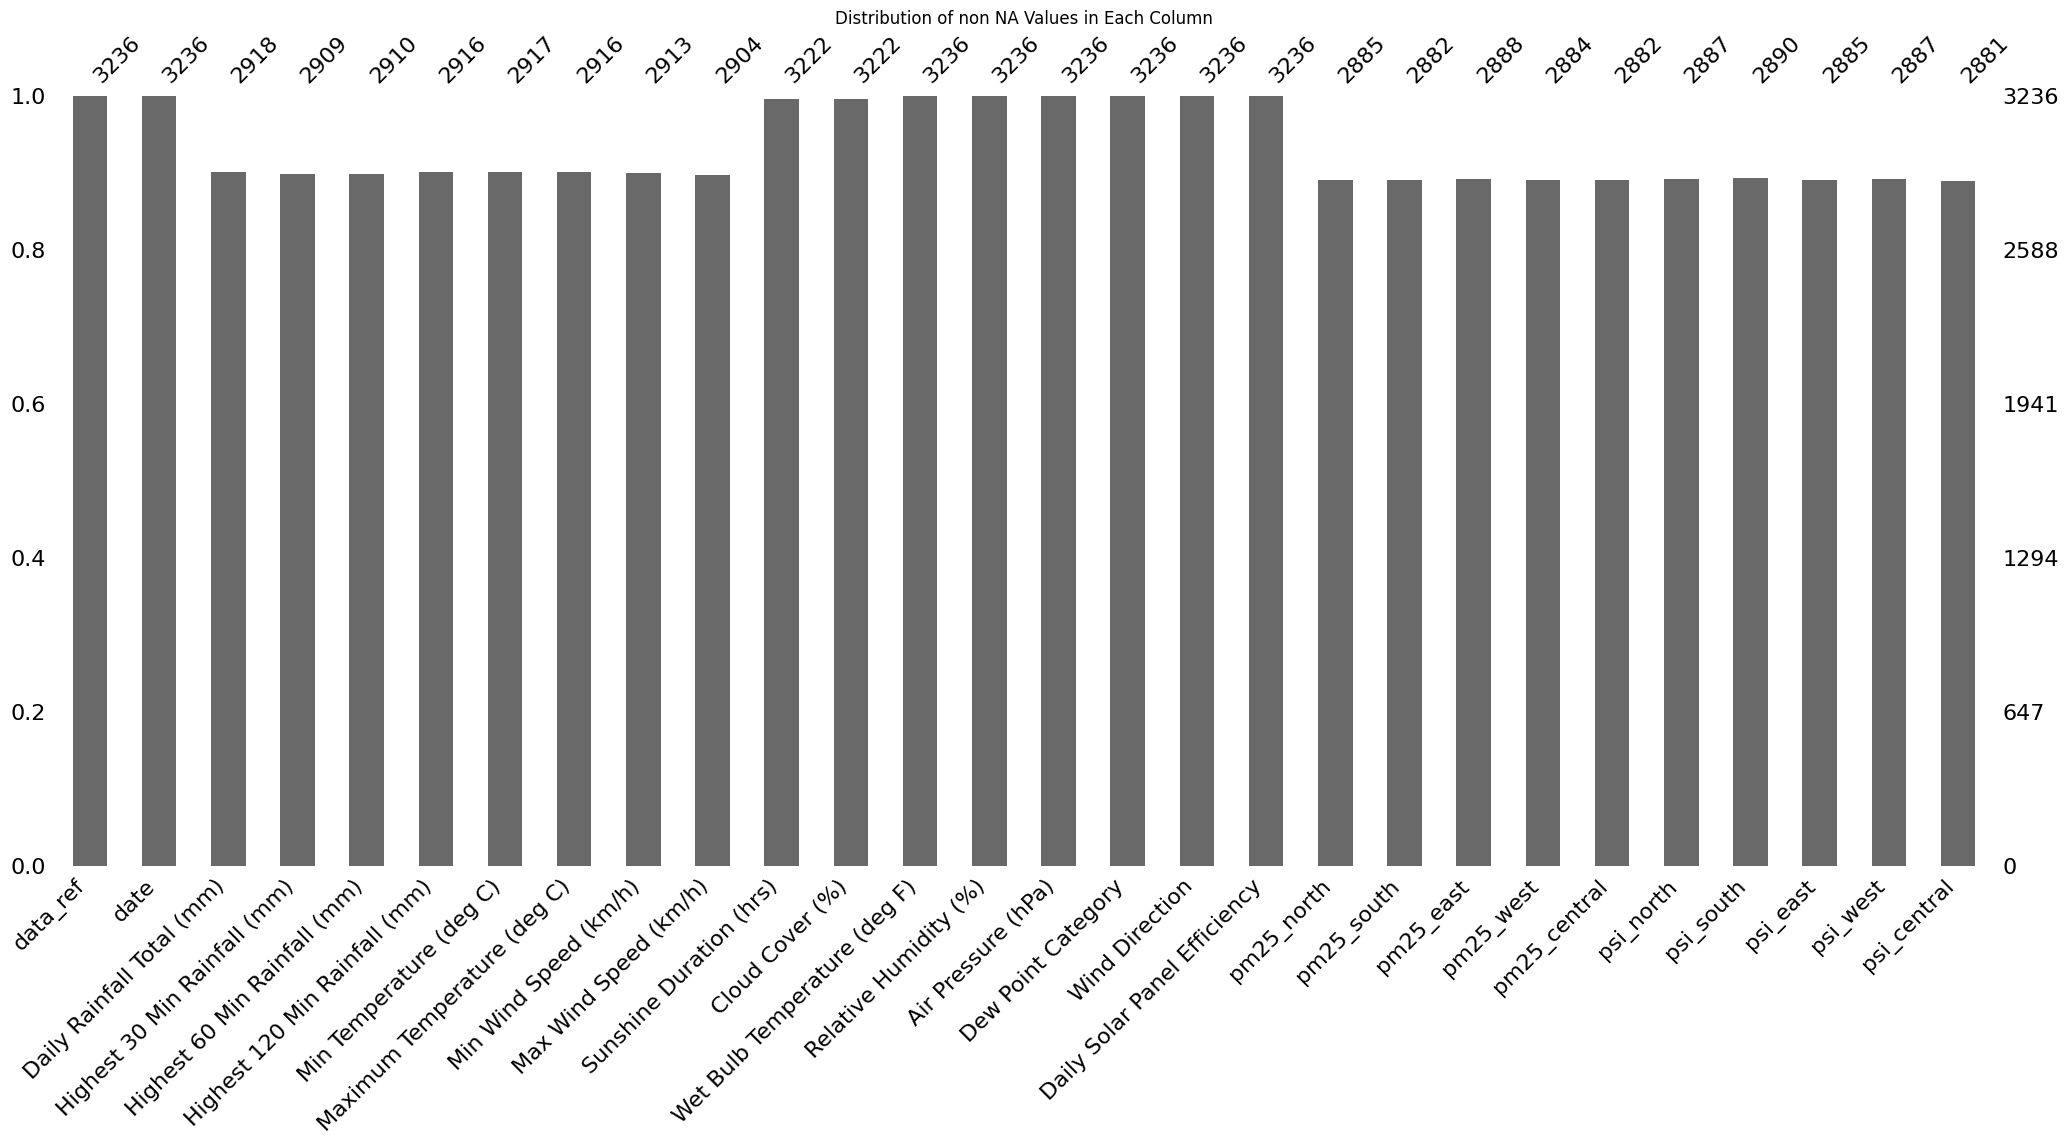

In [9]:
import missingno as msno

import matplotlib.pyplot as plt

# Plot the distribution of missing values
plt.figure(figsize=(12, 8))
msno.bar(merged_df)
plt.title('Distribution of non NA Values in Each Column')
plt.show()

There are 3 types of missing values: Missing completely at random (MCAR), Missing at random (MAR), Missing not at random (MNAR), where the third type requires new or more data (Fnguyen, 2020). Since we are not able to get new or more dataset in this situation, we will assume that the missing values in this dataset belongs to either MCAR or MAR. 

We will use a robust statistical technique for imputation, which is Multiple Imputation (MI), as it works for both situations. The algorithm that we will use to implement this technique is Multivariate Imputation via Chained Equations since it works for datasets with mixed variable types (Nguyen, 2020). We will use the miceforest Python package, which implements the algorithm, in our pipeline to fill in the missing values without leaking the test set into the training set (Wilson, 2024). An example can be found in the code snippet of the github page: https://github.com/AnotherSamWilson/miceforest?tab=readme-ov-file#implementing-sklearn-pipelines. 

## Outliers

I am not sure if outliers should be capped before or after train-test split. If done before, there might be a risk of leaking training set. If done after, the train and test set might have different distribution?

## Cleaning strings

For the dew point category and the wind direction

In [14]:
# Replace identical words and abbreviations in lowercase words 
## Dew Point Category column replacements
dew_point_replacements = {
    'VH': 'very high', 'VERY HIGH': 'very high', 'Very High': 'very high',
    'L': 'low', 'Low': 'low', 'LOW': 'low',
    'High': 'high', 'HIGH': 'high', 'H': 'high', 'High Level': 'high',
    'Moderate': 'moderate', 'M': 'moderate', 'MODERATE': 'moderate',
    'Very Low': 'very low', 'VL': 'very low','Minimal':'very low', 'VERY LOW': 'very low',
    'Below Average': 'below average',
    'Extreme': 'extreme',
    'Normal': 'moderate'
}

# Wind Direction column replacements
wind_direction_replacements = {
    'W': 'west', 'W.': 'west', 'WEST': 'west',
    'E': 'east', 'E.': 'east', 'EAST': 'east',
    'S': 'south', 'Southward': 'south', 'SOUTH': 'south', 'S.': 'south',
    'NORTHEAST': 'northeast', 'NE':'northeast', 'NE.': 'northeast',
    'N': 'north', 'NORTH': 'north', 'Northward': 'north', 'N.': 'north',
    'NW': 'northwest', 'NORTHWEST': 'northwest', 'NW.': 'northwest',
    'SOUTHEAST': 'southeast', 'SE': 'southeast', 'SE.': 'southeast',
    'SW': 'southwest', 'SW.': 'southwest'
    
}

# Apply replacements
merged_df['Dew Point Category'] = merged_df['Dew Point Category'].replace(dew_point_replacements)
merged_df['Wind Direction'] = merged_df['Wind Direction'].replace(wind_direction_replacements)

# Define the order of the categories
dew_point_order = ['very low', 'low', 'below average', 'moderate', 'high', 'very high', 'extreme']

# Convert the column to an ordinal variable
merged_df['Dew Point Category'] = pd.Categorical(merged_df['Dew Point Category'], categories=dew_point_order, ordered=True)

# Check the unique words again
columns_to_check = ['Dew Point Category', 'Wind Direction', 'Daily Solar Panel Efficiency']

unique_words = {}
for column in columns_to_check:
    unique_words[column] = merged_df[column].unique()

# Display the unique words again
for column, words in unique_words.items():
    print(f"Unique words in the column '{column}':")
    print(words)
    print()

Unique words in the column 'Dew Point Category':
['very high', 'low', 'high', 'moderate', 'extreme', 'very low', 'below average']
Categories (7, object): ['very low' < 'low' < 'below average' < 'moderate' < 'high' < 'very high' < 'extreme']

Unique words in the column 'Wind Direction':
['west' 'south' 'east' 'northeast' 'northwest' 'southeast' 'southwest'
 'north']

Unique words in the column 'Daily Solar Panel Efficiency':
['High' 'Medium' 'Low']



## Cleaning code

The below class includes all the cleaning steps that we have done in this section. 

In [23]:
import sqlite3
import pandas as pd
import json

class DataCleaning:
    def __init__(self, input_db_path, input_table_name):
        self.input_db_path = input_db_path
        self.input_table_name = input_table_name
        self.dataframe = None

    def load_data(self):
        """Loads data from the SQLite database into a DataFrame."""
        # Establish a connection to the database
        conn = sqlite3.connect(self.input_db_path)

        # Read the data into a DataFrame
        self.dataframe = pd.read_sql_query(f"SELECT * FROM {self.input_table_name}", conn)

        # Close the connection
        conn.close()

    def convert_to_datetime(self, column_name, dayfirst=True):
        """Converts a column to datetime format."""
        if self.dataframe is not None:
            self.dataframe[column_name] = pd.to_datetime(self.dataframe[column_name], dayfirst=dayfirst)
        else:
            raise ValueError("Dataframe is not loaded. Use load_data() first.")

    def convert_to_numeric(self, columns, dtype=float):
        """Converts specified columns to numeric type, coercing errors to NaN."""
        if self.dataframe is not None:
            for col in columns:
                self.dataframe[col] = pd.to_numeric(self.dataframe[col], errors='coerce').astype(dtype)
        else:
            raise ValueError("Dataframe is not loaded. Use load_data() first.")

    def apply_absolute_values(self, columns):
        """Applies absolute values to specified columns."""
        if self.dataframe is not None:
            self.dataframe[columns] = self.dataframe[columns].abs()
        else:
            raise ValueError("Dataframe is not loaded. Use load_data() first.")

    def replace_values(self, column_replacements):
        """Replaces values in specified columns based on replacement dictionaries."""
        if self.dataframe is not None:
            for column, replacements in column_replacements.items():
                self.dataframe[column] = self.dataframe[column].replace(replacements)
        else:
            raise ValueError("Dataframe is not loaded. Use load_data() first.")

    def convert_to_ordinal(self, column_name, order):
        """Converts a column to an ordinal variable based on a defined order."""
        if self.dataframe is not None:
            self.dataframe[column_name] = pd.Categorical(self.dataframe[column_name], categories=order, ordered=True)
        else:
            raise ValueError("Dataframe is not loaded. Use load_data() first.")

    def save_category_metadata(self, metadata, metadata_path):
        """Saves category metadata to a JSON file."""
        with open(metadata_path, "w") as f:
            json.dump(metadata, f)

    def get_dataframe(self):
        """Returns the cleaned DataFrame."""
        if self.dataframe is not None:
            return self.dataframe
        else:
            raise ValueError("Dataframe is not loaded. Use load_data() first.")

    def save_cleaned_data(self, cleaned_df, output_db_path, output_table_name):
        """
        Save the cleaned DataFrame back into a SQLite database.

        :param merged_df: The cleaned DataFrame to save.
        :param output_db_path: Path to the output SQLite database.
        :param output_table_name: Name of the table to save the cleaned data.
        """
        with sqlite3.connect(output_db_path) as conn:
            cleaned_df.to_sql(output_table_name, conn, if_exists="replace", index=False)

# Example usage
if __name__ == "__main__":
    # Path to the merged database
    merged_db_path = "data/merged_data.db"

    # Initialize the DataCleaning class
    cleaner = DataCleaning(input_db_path=merged_db_path, input_table_name="merged_data")

    # Load data
    cleaner.load_data()

    # Convert date column to datetime
    cleaner.convert_to_datetime("date", dayfirst=True)

    # Convert specified columns to numeric
    columns_to_convert = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central',
                          'psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']
    cleaner.convert_to_numeric(columns_to_convert)

    columns_to_convert2 = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
                           'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
                           'Min Temperature (deg C)', 'Maximum Temperature (deg C)',
                           'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)']
    cleaner.convert_to_numeric(columns_to_convert2, dtype=float)

    # Apply absolute values to specified columns
    columns_to_abs = ['Max Wind Speed (km/h)', 'Wet Bulb Temperature (deg F)']
    cleaner.apply_absolute_values(columns_to_abs)

    # Replace identical words and abbreviations in lowercase words
    column_replacements = {
        'Dew Point Category': {
            'VH': 'very high', 'VERY HIGH': 'very high', 'Very High': 'very high',
            'L': 'low', 'Low': 'low', 'LOW': 'low',
            'High': 'high', 'HIGH': 'high', 'H': 'high', 'High Level': 'high',
            'Moderate': 'moderate', 'M': 'moderate', 'MODERATE': 'moderate',
            'Very Low': 'very low', 'VL': 'very low','Minimal':'very low', 'VERY LOW': 'very low',
            'Below Average': 'below average',
            'Extreme': 'extreme',
            'Normal': 'moderate'
        },
        'Wind Direction': {
            'W': 'west', 'W.': 'west', 'WEST': 'west',
            'E': 'east', 'E.': 'east', 'EAST': 'east',
            'S': 'south', 'Southward': 'south', 'SOUTH': 'south', 'S.': 'south',
            'NORTHEAST': 'northeast', 'NE':'northeast', 'NE.': 'northeast',
            'N': 'north', 'NORTH': 'north', 'Northward': 'north', 'N.': 'north',
            'NW': 'northwest', 'NORTHWEST': 'northwest', 'NW.': 'northwest',
            'SOUTHEAST': 'southeast', 'SE': 'southeast', 'SE.': 'southeast',
            'SW': 'southwest', 'SW.': 'southwest'
        }
    }
    cleaner.replace_values(column_replacements)

    # Define the order of the Dew Point Category
    dew_point_order = ['very low', 'low', 'below average', 'moderate', 'high', 'very high', 'extreme']

    # Convert Dew Point Category column to an ordinal variable
    cleaner.convert_to_ordinal('Dew Point Category', dew_point_order)

    effiency_order = ['Low', 'Medium', 'High']

    # Convert Daily Solar Panel Efficiency column to an ordinal variable
    cleaner.convert_to_ordinal('Daily Solar Panel Efficiency', effiency_order)

    # Save category metadata
    category_metadata = {
        'Dew Point Category': dew_point_order,
        'Daily Solar Panel Efficiency': effiency_order
    }
    cleaner.save_category_metadata(category_metadata, "data/category_metadata.json")

    # Get and display the cleaned DataFrame
    cleaned_df = cleaner.get_dataframe()

    output_db_path = "data/cleaned_data.db"  # Path to save the cleaned data
    output_table_name = "cleaned_data"  # Table name for cleaned data
    # Save the cleaned data back into a database
    cleaner.save_cleaned_data(cleaned_df, output_db_path, output_table_name)


Double check that the df has been cleaned

In [14]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3236 non-null   object        
 1   date                           3236 non-null   datetime64[ns]
 2   Daily Rainfall Total (mm)      2918 non-null   float64       
 3   Highest 30 Min Rainfall (mm)   2909 non-null   float64       
 4   Highest 60 Min Rainfall (mm)   2910 non-null   float64       
 5   Highest 120 Min Rainfall (mm)  2916 non-null   float64       
 6   Min Temperature (deg C)        2917 non-null   float64       
 7   Maximum Temperature (deg C)    2916 non-null   float64       
 8   Min Wind Speed (km/h)          2913 non-null   float64       
 9   Max Wind Speed (km/h)          2904 non-null   float64       
 10  Sunshine Duration (hrs)        3222 non-null   float64       
 11  Cloud Cover (%)  

---

# EDA

After cleaning our weather and air quality data, I performed an in-depth Exploratory Data Analysis. This includes multivariate analysis, time series analysis and Principle component analysis. Let's walk through each component of our EDA process

1. The `multivariate_analysis` method explores insights into relationships among multiple variables
2. The `time_series_analysis` method focuses on temporal patterns in the daily solar panel efficiency

In [7]:
import sqlite3
import pandas as pd

# Path to the merged database
clean_db_path = "data/cleaned_data.db"

# Establish a connection to the database
conn = sqlite3.connect(clean_db_path)

# Read the merged data into a DataFrame
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_data", conn)

# Close the connection
conn.close()

# Load category metadata
with open("data/category_metadata.json", "r") as f:
    category_metadata = json.load(f)

# Convert columns back to categorical
for column, categories in category_metadata.items():
    cleaned_df[column] = pd.Categorical(cleaned_df[column], categories=categories, ordered=True)

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   data_ref                       3236 non-null   object  
 1   date                           3236 non-null   object  
 2   Daily Rainfall Total (mm)      2918 non-null   float64 
 3   Highest 30 Min Rainfall (mm)   2909 non-null   float64 
 4   Highest 60 Min Rainfall (mm)   2910 non-null   float64 
 5   Highest 120 Min Rainfall (mm)  2916 non-null   float64 
 6   Min Temperature (deg C)        2917 non-null   float64 
 7   Maximum Temperature (deg C)    2916 non-null   float64 
 8   Min Wind Speed (km/h)          2913 non-null   float64 
 9   Max Wind Speed (km/h)          2904 non-null   float64 
 10  Sunshine Duration (hrs)        3222 non-null   float64 
 11  Cloud Cover (%)                3222 non-null   float64 
 12  Wet Bulb Temperature (deg F)   323

## Multivariate analysis

Plots a heatmap of correlation of all numeric and categorical variables to see which variables are associated with each other.

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Convert ordinal categorical columns to their numerical codes
df = cleaned_df.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

df =  df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = df.corr()

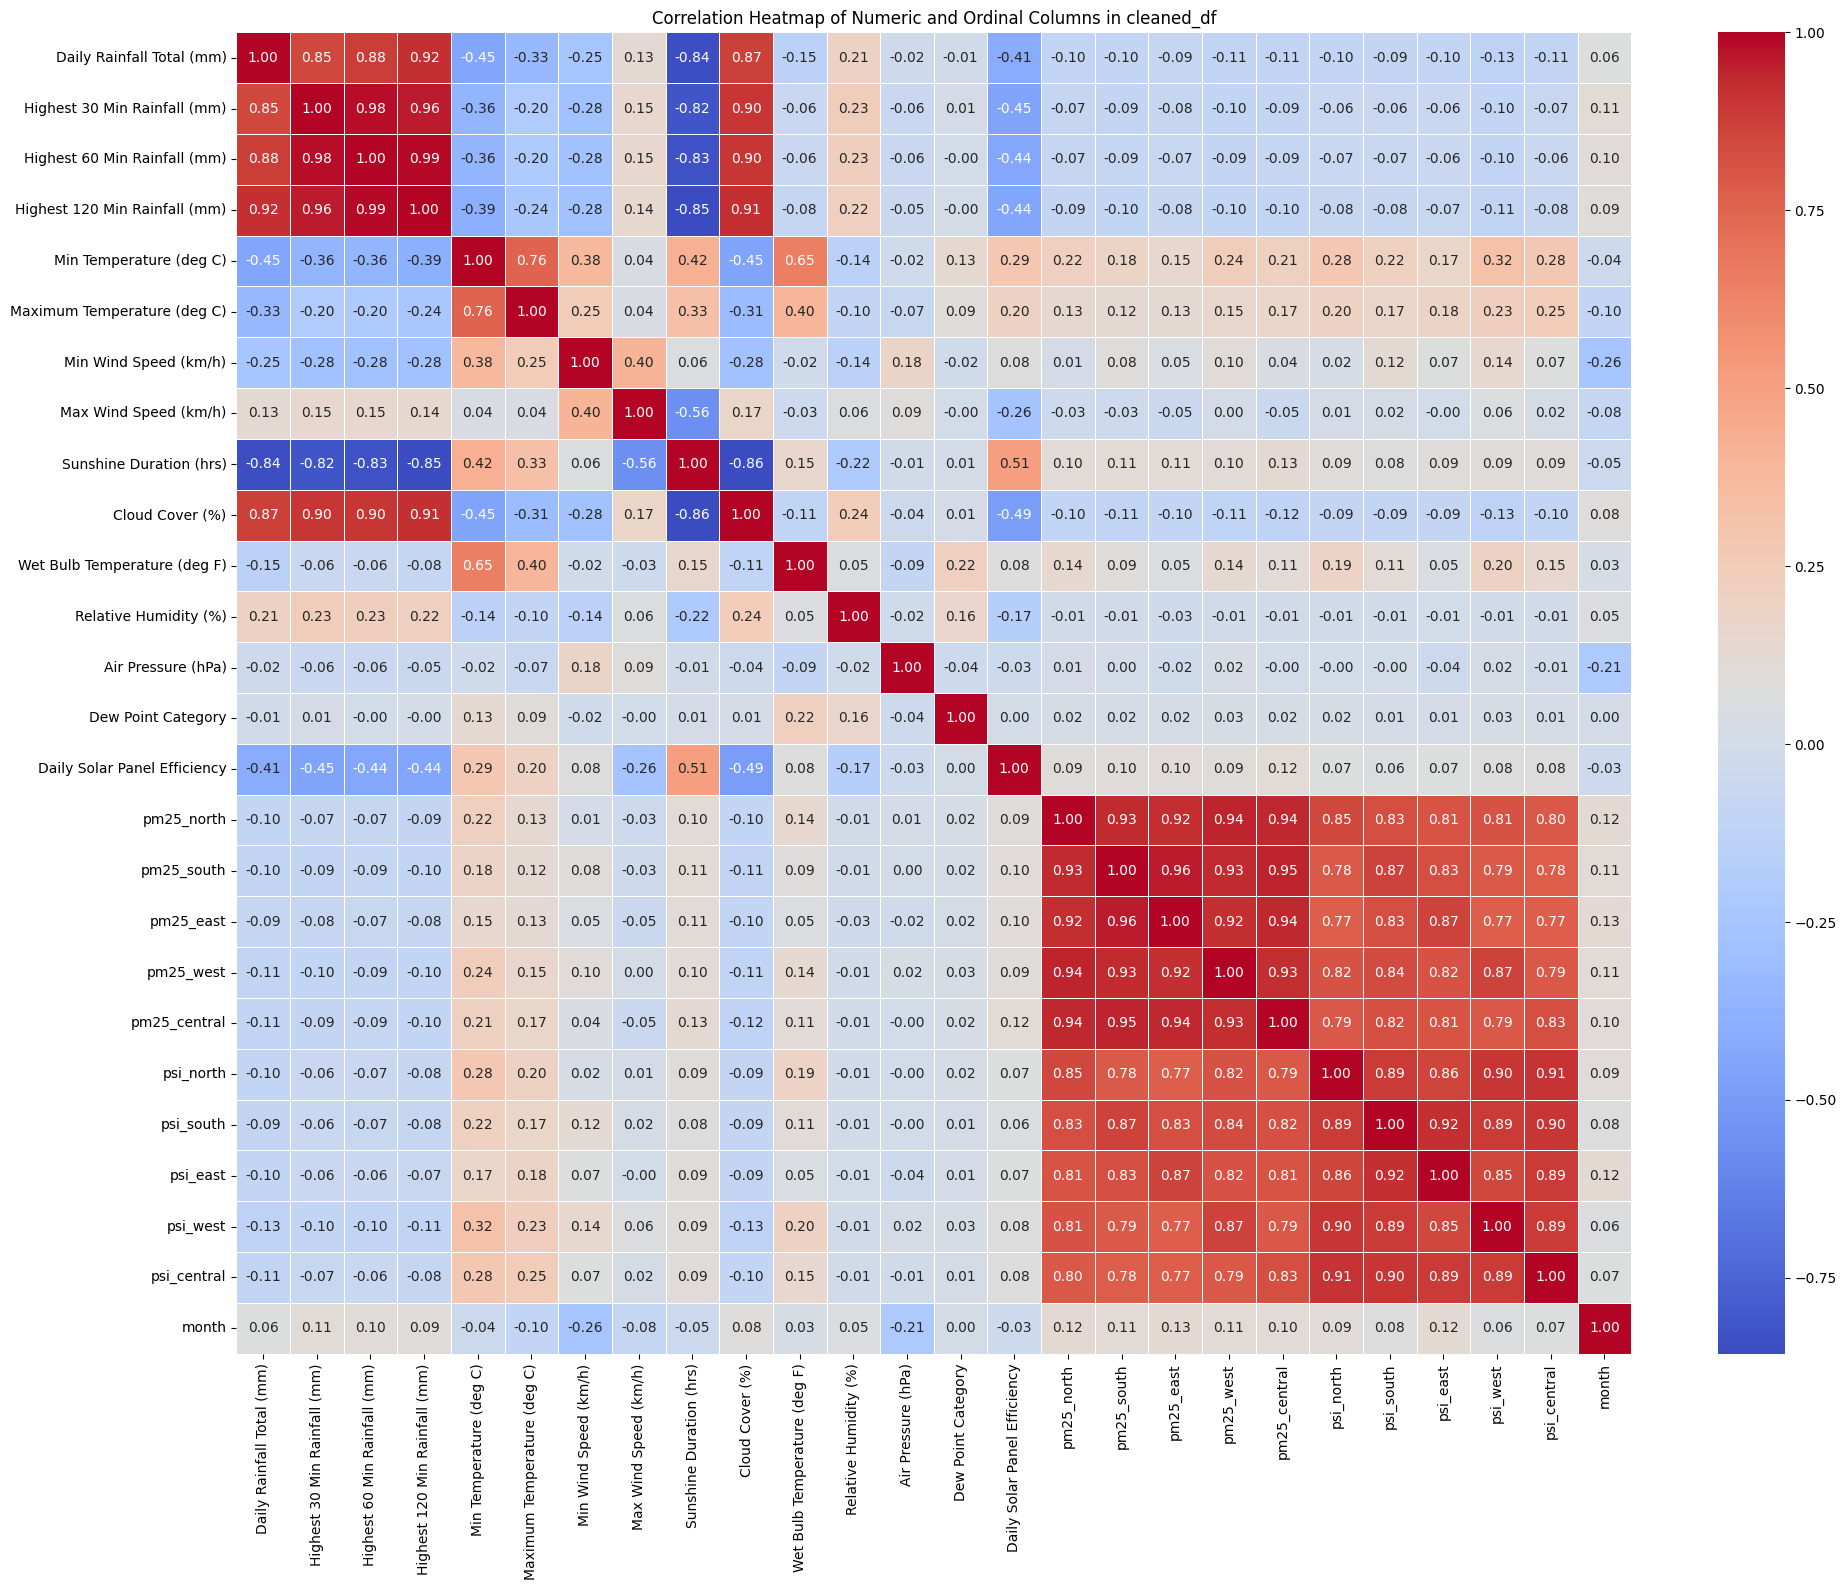

In [12]:
# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Numeric and Ordinal Columns in cleaned_df')
plt.tight_layout()
plt.show()

Observations from the heatmap:

1. Psi, wet bulb temperature, dew point category and air pressure have very minimal effects on the solar panel efficiency.

2. Rainfall contribute greatly to lessen the solar panel efficiency, however, how heavy is the rain does not make a difference to solar panel efficiency. 
3. Higher Cloud Cover(%) cause the solar panel efficiency to reduce significantly.
4. Sunshine Duration greatly increase the solar panel efficiency output.
5. Warmer temperature(deg C) is correlated with higher solar panel efficiency.

We also see some surprising observations:

6. Solar panel efficiency does not show much correlation with min wind speed but is negatively correlated with max wind speed
7. Solar panel efficiency does not show much correlation with pm2.5 even though dust and pollutants on the panel surface can lower the amount of sunlight that reaches the photovoltaic cells (Lalaeng et al., 2024)  

### Next steps:

1. We will not use the variables mentioned in point 1 to train the prediction model since they might introduce noise into the model
2. For variables mentioned in points 2 to 5, some of them are strongly correlated with each other while other are correlated so we will explore some dimension reduction techniques like PCA so as to minimise the effect of multicollinearity on the model (Biswal, 2024). 
3. We might explore more into the surprising observations mentioned in point 6 & 7 to determine if we want to include these variables for the prediction or if feature engineering is a suitable
4. We will also do time series analysis by month since the weather usually follows a yearly pattern to see if there is a need for any feature engineering for the model. 

In [13]:
# Create a contingency table (cross-tabulation)
contingency_table = cleaned_df.pivot_table(
    index='Wind Direction',
    columns='Daily Solar Panel Efficiency',
    aggfunc='size',
    fill_value=0  # Fill missing combinations with 0
)


C:\Users\yipin\AppData\Local\Temp\ipykernel_11980\329258763.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  contingency_table = cleaned_df.pivot_table(


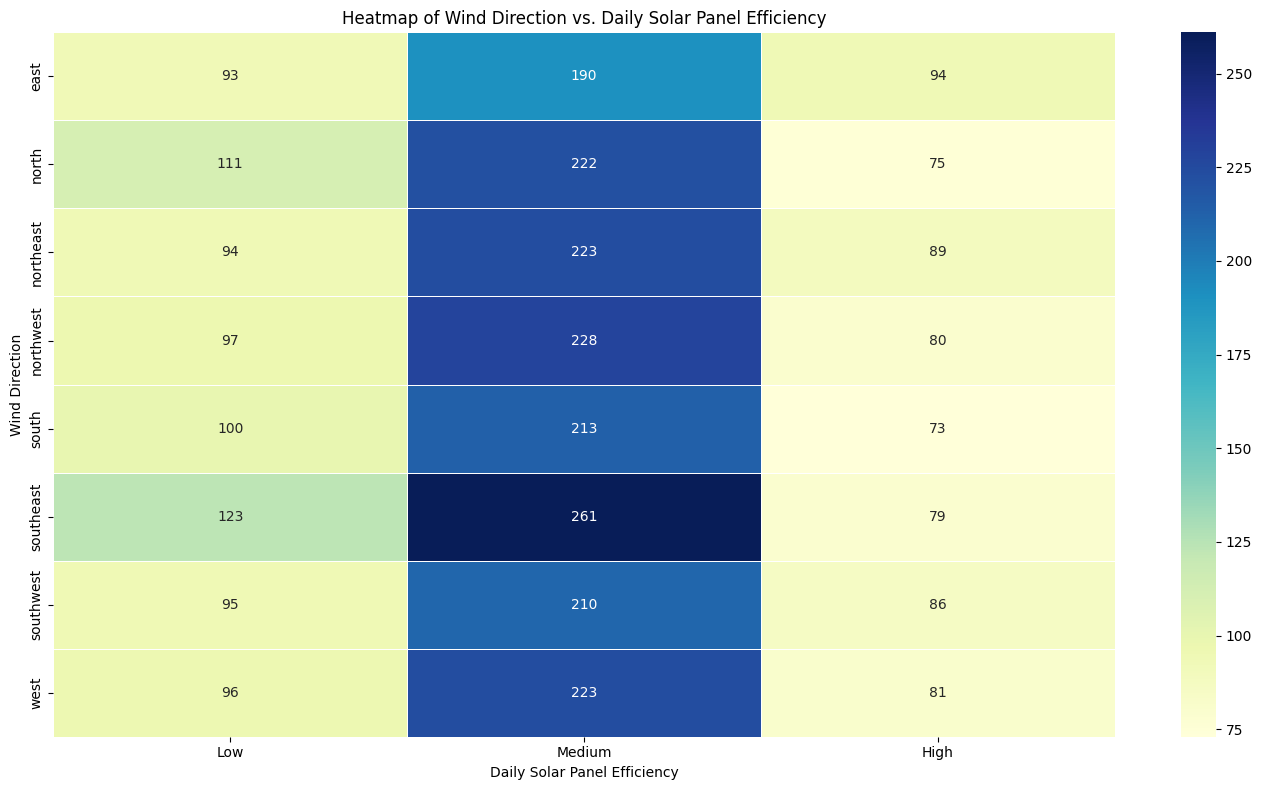

In [14]:
# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    contingency_table, 
    annot=True, 
    cmap='YlGnBu', 
    linewidths=0.5, 
    fmt='d'  # Format as integers since we are counting occurrences
)
plt.title('Heatmap of Wind Direction vs. Daily Solar Panel Efficiency')
plt.xlabel('Daily Solar Panel Efficiency')
plt.ylabel('Wind Direction')
plt.tight_layout()
plt.show()

We observe that 
1. southeast wind direction is associated with more low and medium Daily solar panel efficiency
2. east wind direction is associated with more high daily solar panel efficiency

We will use the Chi-Square Test for Independence to evaluate whether there is a significant association between wind direction and solar panel efficiency levels. 

In [15]:
from scipy.stats import chi2_contingency

# Perform the Chi-Square test for independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

p

np.float64(0.5374948844160727)

Since the p-value is 0.537, which is greater than the typical significance level (e.g., 0.05), this suggests that we fail to reject the null hypothesis, meaning there is no statistically significant association between wind direction and daily solar panel efficiency levels.

As such, we will not include the wind direction in our model training as well. 

___

## Time Series analysis

Observing for seasonal patterns in the solar panel efficiency and other weather data

In [19]:
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df['month'] = cleaned_df['date'].dt.month
cleaned_df['Efficiency_num'] = cleaned_df['Daily Solar Panel Efficiency'].cat.codes

C:\Users\yipin\AppData\Local\Temp\ipykernel_11980\1801902693.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = cleaned_df.groupby(['month', 'Daily Solar Panel Efficiency']).size().unstack(fill_value=0)


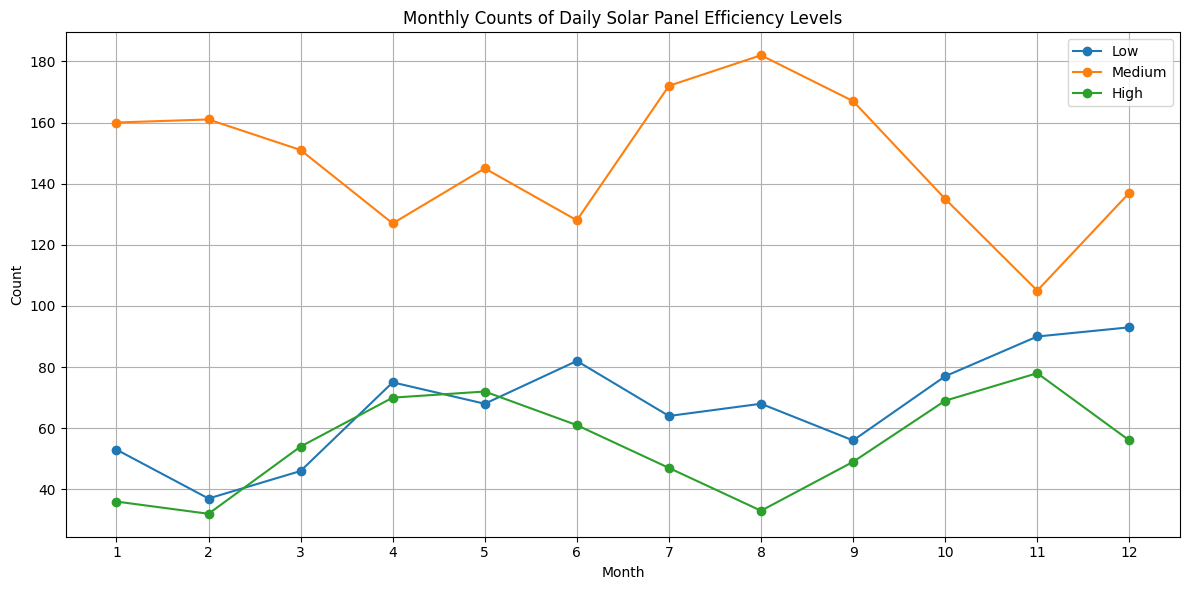

In [20]:
import matplotlib.pyplot as plt

# Group by month and Daily Solar Panel Efficiency, then count the occurrences
monthly_counts = cleaned_df.groupby(['month', 'Daily Solar Panel Efficiency']).size().unstack(fill_value=0)

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts['Low'], marker='o', label='Low')
plt.plot(monthly_counts.index, monthly_counts['Medium'], marker='o', label='Medium')
plt.plot(monthly_counts.index, monthly_counts['High'], marker='o', label='High')

# Add titles and labels
plt.title('Monthly Counts of Daily Solar Panel Efficiency Levels')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))  # Ensure x-axis has 12 months

# Show the plot
plt.tight_layout()
plt.show()

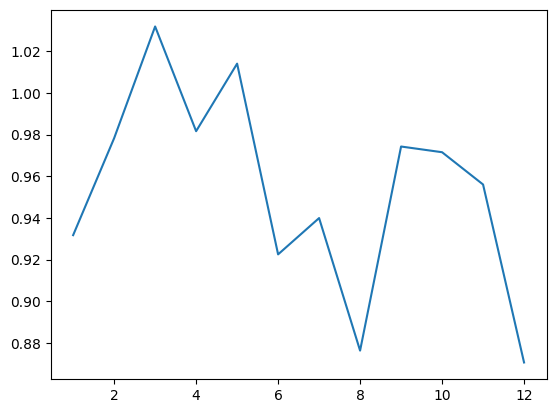

In [22]:
plt.plot(cleaned_df['Efficiency_num'].groupby(cleaned_df['month']).mean())

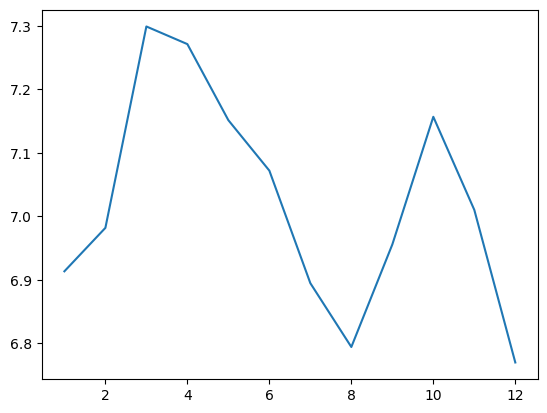

In [42]:
plt.plot(cleaned_df['Sunshine Duration (hrs)'].groupby(cleaned_df['month']).mean())

We can see that weather conditions like sunshine duration also changes with time and such change over time affects the solar panel efficiency so we will feature engineer the month and include it in the PCA. 

## PCA

We will do a PCA of these columns in the cleaned_df: 
1. All the rainfall columns
2. Cloud Cover
3. Sunchine Duration
4. Temperature columns
5. month

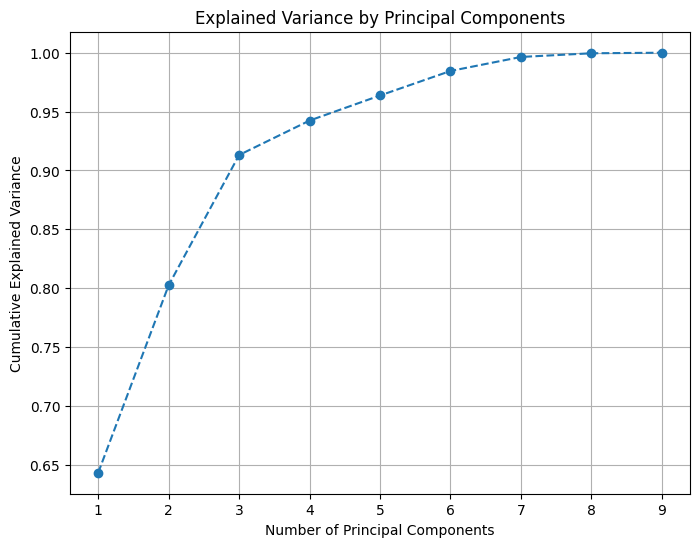

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select columns properly using a list
columns = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)', 
           'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 
           'Cloud Cover (%)', 
           'Sunshine Duration (hrs)',
           'month']

# Extract the data and handle missing values
pca_data = cleaned_df[columns].dropna()  # Remove rows with missing values

# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(pca_data)

# Perform PCA on normalized data
pca = PCA()
pca.fit(normalized_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting the PCA curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


We can see that the marginal gain in the cumulative explained variance reduces significantly after from 4 principal components onwards. Furthermore, 5 principal components is able to account for >95% of the variance, halving the dimensions. This confirms that there is a need to do PCA before prediction to reduce multi-collinearity which will affect the prediction models. Therefore, for preprocessing of the training and testing data, we will set `n_components = 0.95` for the PCA transform

# Preprocessing

Summary of preprocessing steps:

1. feature engineering
2. Dropping of columns
3. Fill in missing values using mice
4. Standardise remaining columns
5. Do PCA of relevant columns

In [49]:
import sqlite3
import pandas as pd
import json

# Path to the merged database
clean_db_path = "data/cleaned_data.db"

# Establish a connection to the database
conn = sqlite3.connect(clean_db_path)

# Read the merged data into a DataFrame
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_data", conn)

# Close the connection
conn.close()

# Load category metadata
with open("data/category_metadata.json", "r") as f:
    category_metadata = json.load(f)

# Convert columns back to categorical
for column, categories in category_metadata.items():
    cleaned_df[column] = pd.Categorical(cleaned_df[column], categories=categories, ordered=True)

# Convert ordinal categorical columns to their numerical codes
cleaned_df = cleaned_df.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df['month'] = cleaned_df['date'].dt.month


In [2]:
cleaned_df.columns

Index(['data_ref', 'date', 'Daily Rainfall Total (mm)',
       'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)',
       'Highest 120 Min Rainfall (mm)', 'Min Temperature (deg C)',
       'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'Sunshine Duration (hrs)', 'Cloud Cover (%)',
       'Wet Bulb Temperature (deg F)', 'Relative Humidity (%)',
       'Air Pressure (hPa)', 'Dew Point Category', 'Wind Direction',
       'Daily Solar Panel Efficiency', 'pm25_north', 'pm25_south', 'pm25_east',
       'pm25_west', 'pm25_central', 'psi_north', 'psi_south', 'psi_east',
       'psi_west', 'psi_central', 'month'],
      dtype='object')

## Dropping columns

In [54]:
X = cleaned_df.drop(['Daily Solar Panel Efficiency',  
                           'date', 
                           'data_ref', 
                           'psi_north', 'psi_south', 'psi_east','psi_west', 'psi_central', 
                           'pm25_north', 'pm25_south', 'pm25_east','pm25_west',
                           'Wet Bulb Temperature (deg F)', 'Air Pressure (hPa)', 'Dew Point Category'
                           ], axis=1)

y = cleaned_df['Daily Solar Panel Efficiency']

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      2918 non-null   float64
 1   Highest 30 Min Rainfall (mm)   2909 non-null   float64
 2   Highest 60 Min Rainfall (mm)   2910 non-null   float64
 3   Highest 120 Min Rainfall (mm)  2916 non-null   float64
 4   Min Temperature (deg C)        2917 non-null   float64
 5   Maximum Temperature (deg C)    2916 non-null   float64
 6   Min Wind Speed (km/h)          2913 non-null   float64
 7   Max Wind Speed (km/h)          2904 non-null   float64
 8   Sunshine Duration (hrs)        3222 non-null   float64
 9   Cloud Cover (%)                3222 non-null   float64
 10  Relative Humidity (%)          3236 non-null   float64
 11  Wind Direction                 3236 non-null   object 
 12  pm25_central                   2882 non-null   f

In [5]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3236 entries, 0 to 3235
Series name: Daily Solar Panel Efficiency
Non-Null Count  Dtype
--------------  -----
3236 non-null   int8 
dtypes: int8(1)
memory usage: 3.3 KB


## One hot encoding

In [57]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

# Fit and transform the single column
encoded = encoder.fit_transform(X[['Wind Direction']])

# Convert to a DataFrame
column_names = encoder.get_feature_names_out(['Wind Direction'])
encoded_df = pd.DataFrame(encoded.toarray(), columns=column_names)

# Combine with the rest of the original dataset
X_encoded = pd.concat([X.drop(columns=['Wind Direction']), encoded_df], axis=1)

In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      2918 non-null   float64
 1   Highest 30 Min Rainfall (mm)   2909 non-null   float64
 2   Highest 60 Min Rainfall (mm)   2910 non-null   float64
 3   Highest 120 Min Rainfall (mm)  2916 non-null   float64
 4   Min Temperature (deg C)        2917 non-null   float64
 5   Maximum Temperature (deg C)    2916 non-null   float64
 6   Min Wind Speed (km/h)          2913 non-null   float64
 7   Max Wind Speed (km/h)          2904 non-null   float64
 8   Sunshine Duration (hrs)        3222 non-null   float64
 9   Cloud Cover (%)                3222 non-null   float64
 10  Relative Humidity (%)          3236 non-null   float64
 11  Wind Direction                 3236 non-null   object 
 12  pm25_central                   2882 non-null   f

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      2918 non-null   float64
 1   Highest 30 Min Rainfall (mm)   2909 non-null   float64
 2   Highest 60 Min Rainfall (mm)   2910 non-null   float64
 3   Highest 120 Min Rainfall (mm)  2916 non-null   float64
 4   Min Temperature (deg C)        2917 non-null   float64
 5   Maximum Temperature (deg C)    2916 non-null   float64
 6   Min Wind Speed (km/h)          2913 non-null   float64
 7   Max Wind Speed (km/h)          2904 non-null   float64
 8   Sunshine Duration (hrs)        3222 non-null   float64
 9   Cloud Cover (%)                3222 non-null   float64
 10  Relative Humidity (%)          3236 non-null   float64
 11  pm25_central                   2882 non-null   float64
 12  month                          3236 non-null   i

In [59]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      2918 non-null   float64
 1   Highest 30 Min Rainfall (mm)   2909 non-null   float64
 2   Highest 60 Min Rainfall (mm)   2910 non-null   float64
 3   Highest 120 Min Rainfall (mm)  2916 non-null   float64
 4   Min Temperature (deg C)        2917 non-null   float64
 5   Maximum Temperature (deg C)    2916 non-null   float64
 6   Min Wind Speed (km/h)          2913 non-null   float64
 7   Max Wind Speed (km/h)          2904 non-null   float64
 8   Sunshine Duration (hrs)        3222 non-null   float64
 9   Cloud Cover (%)                3222 non-null   float64
 10  Relative Humidity (%)          3236 non-null   float64
 11  pm25_central                   2882 non-null   float64
 12  month                          3236 non-null   i

In [60]:
X_sample = X.head(20)
# Fit and transform the single column
encoded = encoder.fit_transform(X_sample[['Wind Direction']])

# Convert to a DataFrame
column_names = encoder.get_feature_names_out(['Wind Direction'])
encoded_df = pd.DataFrame(encoded.toarray(), columns=column_names)

# Combine with the rest of the original dataset
X_sample_encoded = pd.concat([X_sample.drop(columns=['Wind Direction']), encoded_df], axis=1)

X_sample_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      18 non-null     float64
 1   Highest 30 Min Rainfall (mm)   19 non-null     float64
 2   Highest 60 Min Rainfall (mm)   19 non-null     float64
 3   Highest 120 Min Rainfall (mm)  16 non-null     float64
 4   Min Temperature (deg C)        20 non-null     float64
 5   Maximum Temperature (deg C)    19 non-null     float64
 6   Min Wind Speed (km/h)          18 non-null     float64
 7   Max Wind Speed (km/h)          18 non-null     float64
 8   Sunshine Duration (hrs)        20 non-null     float64
 9   Cloud Cover (%)                20 non-null     float64
 10  Relative Humidity (%)          20 non-null     float64
 11  pm25_central                   17 non-null     float64
 12  month                          20 non-null     int32

In [56]:
X_sample_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      18 non-null     float64
 1   Highest 30 Min Rainfall (mm)   19 non-null     float64
 2   Highest 60 Min Rainfall (mm)   19 non-null     float64
 3   Highest 120 Min Rainfall (mm)  16 non-null     float64
 4   Min Temperature (deg C)        20 non-null     float64
 5   Maximum Temperature (deg C)    19 non-null     float64
 6   Min Wind Speed (km/h)          18 non-null     float64
 7   Max Wind Speed (km/h)          18 non-null     float64
 8   Sunshine Duration (hrs)        20 non-null     float64
 9   Cloud Cover (%)                20 non-null     float64
 10  Relative Humidity (%)          20 non-null     float64
 11  pm25_central                   17 non-null     float64
 12  month                          20 non-null     int32

## Fill in missing values

In [26]:
import miceforest as mf
# Create kernel. 
kernel = mf.ImputationKernel(
  X,
  num_datasets=4,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(iterations=2)

# Printing the kernel will show you some high level information.
print(kernel)


              Class: ImputationKernel
            Datasets: 4
          Iterations: 2
        Data Samples: 3236
        Data Columns: 21
   Imputed Variables: 11
   Modeled Variables: 11
All Iterations Saved: True
        


In [27]:
X_filled = kernel.complete_data(dataset=2)

X_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      3236 non-null   float64
 1   Highest 30 Min Rainfall (mm)   3236 non-null   float64
 2   Highest 60 Min Rainfall (mm)   3236 non-null   float64
 3   Highest 120 Min Rainfall (mm)  3236 non-null   float64
 4   Min Temperature (deg C)        3236 non-null   float64
 5   Maximum Temperature (deg C)    3236 non-null   float64
 6   Min Wind Speed (km/h)          3236 non-null   float64
 7   Max Wind Speed (km/h)          3236 non-null   float64
 8   Sunshine Duration (hrs)        3236 non-null   float64
 9   Cloud Cover (%)                3236 non-null   float64
 10  Relative Humidity (%)          3236 non-null   float64
 11  pm25_central                   3236 non-null   float64
 12  month                          3236 non-null   i

In [38]:
X_sample = X.head(20)

X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      18 non-null     float64
 1   Highest 30 Min Rainfall (mm)   19 non-null     float64
 2   Highest 60 Min Rainfall (mm)   19 non-null     float64
 3   Highest 120 Min Rainfall (mm)  16 non-null     float64
 4   Min Temperature (deg C)        20 non-null     float64
 5   Maximum Temperature (deg C)    19 non-null     float64
 6   Min Wind Speed (km/h)          18 non-null     float64
 7   Max Wind Speed (km/h)          18 non-null     float64
 8   Sunshine Duration (hrs)        20 non-null     float64
 9   Cloud Cover (%)                20 non-null     float64
 10  Relative Humidity (%)          20 non-null     float64
 11  pm25_central                   17 non-null     float64
 12  month                          20 non-null     int32

In [39]:
kernel.transform(X_sample)

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),...,pm25_central,month,Wind Direction_east,Wind Direction_north,Wind Direction_northeast,Wind Direction_northwest,Wind Direction_south,Wind Direction_southeast,Wind Direction_southwest,Wind Direction_west
0,0.0,2.0,2.0,2.0,28.4,32.4,7.5,25.9,8.07,18.0,...,19.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.2,28.8,32.6,9.7,33.1,7.57,23.0,...,16.0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,29.3,32.6,8.3,43.2,6.72,16.0,...,10.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,28.6,32.4,7.4,33.1,7.55,20.0,...,25.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,23.4,15.2,17.2,17.4,26.4,28.0,5.4,28.1,5.27,74.0,...,17.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.2,0.2,0.2,0.2,28.0,32.5,10.4,34.6,7.39,13.0,...,11.0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,10.0,9.8,10.0,0.0,28.6,34.5,7.6,43.2,5.75,40.0,...,10.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,6.6,4.2,4.8,6.2,27.6,32.8,6.9,38.5,7.47,35.0,...,19.0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1.8,1.4,1.8,1.8,27.6,34.0,7.2,37.1,7.13,10.0,...,18.0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,3.0,0.0,0.0,28.0,31.8,6.2,29.2,7.88,15.0,...,14.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Putting all together

In [71]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import miceforest as mf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve,precision_score, accuracy_score, recall_score, f1_score
import numpy as np

In [62]:
import sqlite3
import pandas as pd
import json

# Path to the merged database
clean_db_path = "data/cleaned_data.db"

# Establish a connection to the database
conn = sqlite3.connect(clean_db_path)

# Read the merged data into a DataFrame
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_data", conn)

# Close the connection
conn.close()

# Load category metadata
with open("data/category_metadata.json", "r") as f:
    category_metadata = json.load(f)

# Convert columns back to categorical
for column, categories in category_metadata.items():
    cleaned_df[column] = pd.Categorical(cleaned_df[column], categories=categories, ordered=True)

# Convert ordinal categorical columns to their numerical codes
cleaned_df = cleaned_df.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df['month'] = cleaned_df['date'].dt.month

In [63]:
X = cleaned_df.drop(['Daily Solar Panel Efficiency',  
                           'date', 
                           'data_ref', 
                           'psi_north', 'psi_south', 'psi_east','psi_west', 'psi_central', 
                           'pm25_north', 'pm25_south', 'pm25_east','pm25_west',
                           'Wet Bulb Temperature (deg F)', 'Air Pressure (hPa)', 'Dew Point Category'
                           ], axis=1)

y = cleaned_df['Daily Solar Panel Efficiency']

In [64]:
# Split the data into training and testing sets#
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2588 entries, 2933 to 3174
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      2336 non-null   float64
 1   Highest 30 Min Rainfall (mm)   2333 non-null   float64
 2   Highest 60 Min Rainfall (mm)   2321 non-null   float64
 3   Highest 120 Min Rainfall (mm)  2334 non-null   float64
 4   Min Temperature (deg C)        2332 non-null   float64
 5   Maximum Temperature (deg C)    2335 non-null   float64
 6   Min Wind Speed (km/h)          2338 non-null   float64
 7   Max Wind Speed (km/h)          2315 non-null   float64
 8   Sunshine Duration (hrs)        2577 non-null   float64
 9   Cloud Cover (%)                2577 non-null   float64
 10  Relative Humidity (%)          2588 non-null   float64
 11  Wind Direction                 2588 non-null   object 
 12  pm25_central                   2317 non-null   flo

In [45]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 2588 entries, 2933 to 3174
Series name: Daily Solar Panel Efficiency
Non-Null Count  Dtype
--------------  -----
2588 non-null   int8 
dtypes: int8(1)
memory usage: 22.7 KB


In [69]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 123)

# Assume iris_amp is the dataset with missing values
categorical_column = ['Wind Direction']  # Replace with the actual categorical column name

encoder = OneHotEncoder()

scaler = StandardScaler()

pca = PCA(n_components = 0.95)

acc = []
prec = []
rec = []
f1 = []
y_pred = []
y_true = []

for train_i, val_i in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_i], X_train.iloc[val_i] # numpy array
    y_train_fold, y_val_fold = y_train.iloc[train_i], y_train.iloc[val_i] # pd df

    #before using the one hot encoding, we need to reset the index of both the training and validation sets
    X_train_encoded.reset_index(drop=True, inplace=True)
    X_val_encoded.reset_index(drop=True, inplace=True)

    # One hot encoding for the training set
    encoded = encoder.fit_transform(X_train_fold[categorical_column])
    column_names = encoder.get_feature_names_out(['Wind Direction'])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=column_names, index=X_train_fold.index)  # Set index to match
    # Combine with the rest of the original dataset
    X_train_encoded = pd.concat([X_train_fold.drop(columns=['Wind Direction']), encoded_df], axis=1)


    # One hot encoding the validation set
    encoded = encoder.transform(X_val_fold[categorical_column])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=column_names, index=X_val_fold.index)  # Set index to match
    X_val_encoded = pd.concat([X_val_fold.drop(columns=['Wind Direction']), encoded_df], axis=1)

    #before using the mice forest, we need to reset the index of both the training and validation sets
    X_train_encoded.reset_index(drop=True, inplace=True)
    X_val_encoded.reset_index(drop=True, inplace=True)

    # Create kernel.
    kernel = mf.ImputationKernel(
      X_train_encoded,
      num_datasets=4,
      random_state=1
    )

    # Run the MICE algorithm for 2 iterations on each of the datasets
    kernel.mice(iterations=2)
    X_train_filled = kernel.complete_data(dataset=3)
    X_val_filled = kernel.transform(X_val_encoded)

    # Normalise the data
    X_train_normalised = scaler.fit_transform(X_train_filled)
    X_val_normalised = scaler.transform(X_val_filled)

    # PCA
    X_train_pca = pca.fit_transform(X_train_normalised)
    X_val_pca = pca.transform(X_val_normalised)


    log_reg = LogisticRegression(random_state = 42, max_iter = 1000)
    log_reg.fit(X_train_pca, y_train_fold)
    preds = log_reg.predict(X_val_pca)
    y_pred.extend(preds)
    y_true.extend(y_val_fold)

    acc.append(accuracy_score(y_val_fold, preds))
    # multiclass prediction need choose micro or macro for the below 3 metrics, not multiclass dont need to specify
    prec.append(precision_score(y_val_fold, preds, average='micro'))
    rec.append(recall_score(y_val_fold, preds, average='micro'))
    f1.append(f1_score(y_val_fold, preds, average='micro'))

I choose micro average because the predicted class is imbalanced and I am lazy to do oversampling. 

According to what I learnt in class, Micro-averaging is better at handling imbalanced data. (Assuming that this is actual distribution that you are interested).

In [73]:
print(f'Mean accuracy: {np.mean(acc)}')
print(f'Mean precision: {np.mean(prec)}')
print(f'Mean recall: {np.mean(rec)}')
print(f'Mean f1: {np.mean(f1)}')

Mean accuracy: 0.7287394606543544
Mean precision: 0.7287394606543544
Mean recall: 0.7287394606543544
Mean f1: 0.7287394606543544


And yes precision recall and f1 will be equal when you use micro-average